In [9]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from collections import deque, namedtuple
from torch.optim.lr_scheduler import CosineAnnealingLR


class DDQN(nn.Module):

  def __init__(self, state_size, action_size):
    super(DDQN, self).__init__()
    self.fc1 = nn.Linear(state_size, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, action_size)

  def forward(self, state):
    x = self.fc1(state)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    return self.fc3(x)
  

# Defining the hyperparameters


# Implementing the Experience Replay

class Memory(object):

  def __init__(self, memory_buffer_size):
    self.device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")
    self.memory_buffer_size = memory_buffer_size
    self.memory = []

  def push(self, event):
    self.memory.append(event)
    if len(self.memory) > self.memory_buffer_size:
      del self.memory[0]

  def sample(self, batch_size):
    experiences = random.sample(self.memory, k = batch_size)
    states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
    actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
    rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
    next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
    dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
    return states, next_states, actions, rewards, dones


class Agent():

  def __init__(self, state_size, action_size,
               learning_rate = 5e-4, 
               discount_factor = 0.99,
               interpolation_parameter = 1e-3,
               update_every = 4, 
               memory_buffer_size = int(1e5),
               sample_minibatch_size = 100):
    self.device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")
    self.state_size = state_size
    self.action_size = action_size
    # self.learning_rate = learning_rate
    self.discount_factor = discount_factor
    self.interpolation_parameter = interpolation_parameter
    self.update_every = update_every
    self.sample_minibatch_size = sample_minibatch_size
    self.memory_buffer_size = memory_buffer_size
    self.local_model = DDQN(state_size, action_size).to(self.device)
    self.target_model = DDQN(state_size, action_size).to(self.device)
    self.optimizer = optim.Adam(self.local_model.parameters(), lr = learning_rate)
    # self.scheduler = StepLR(self.optimizer, step_size = 10, gamma = 0.9999) # 学习率调度器, 每隔20个epoch, 学习率乘以0.95
    self.scheduler = CosineAnnealingLR(self.optimizer, T_max = 50, eta_min = 0.001) # T_max: 重启周期, eta_min: 学习率下限
    self.memory = Memory(self.memory_buffer_size)
    self.step_count = 0
    self.step_loss = []
    self.loss = 0
    self.losses = []
    self.ema_loss = 0
    self.q_targets = 0
    self.q_expected = 0

  def step(self, state, action, reward, next_state, done):
    self.memory.push((state, action, reward, next_state, done))
    self.step_count = (self.step_count + 1) % self.update_every
    if self.step_count == 0:
      if len(self.memory.memory) > self.sample_minibatch_size:
        experiences = self.memory.sample(self.sample_minibatch_size)
        self.learn(experiences, self.discount_factor)
    

  def act(self, state, epsilon = 0.):
    state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
    self.local_model.eval()
    with torch.no_grad():
      action_values = self.local_model(state)
    self.local_model.train()
    if random.random() > epsilon:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

  def learn(self, experiences, discount_factor):
    states, next_states, actions, rewards, dones = experiences
    next_q_targets = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + discount_factor * next_q_targets * (1 - dones)
    q_expected = self.local_model(states).gather(1, actions)
    loss = F.mse_loss(q_expected, q_targets) # Compute loss

    self.optimizer.zero_grad()
    loss.backward() # Backpropagation
    self.optimizer.step()
    self.scheduler.step()
    self.soft_update(self.local_model, self.target_model, self.interpolation_parameter)
    self.loss = loss.item()
    self.step_loss.append((self.step_count,loss.item()))
    self.ema_loss = (1 - self.interpolation_parameter) * self.ema_loss + self.interpolation_parameter * loss.item() # Exponential moving average of the loss
    self.q_targets = q_targets.mean().item()
    self.q_expected = q_expected.mean().item()
    self.losses.append(loss.item())


  def soft_update(self, local_model, target_model, interpolation_parameter):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)


  def get_loss(self):
    return self.loss
  
  def get_ema_loss(self):
    return self.ema_loss
  
  def get_q_targets(self):
    return self.q_targets
  
  def get_q_expected(self):
    return self.q_expected
  
  def get_average_loss(self):
    if self.losses:
      return np.mean(self.losses)
    return 0

  def reset_average_loss(self):
    self.losses = []

  def get_step_loss(self):
    return self.step_loss



In [11]:

# Setting up the Lunar Environment

import gymnasium as gym
env = gym.make('LunarLander-v2')
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_of_actions = env.action_space.n
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_of_actions)

# Initialize the Agent with the hyperparameters
learning_rate = 5e-4
discount_factor = 0.99
interpolation_parameter = 1e-3
update_every = 4
memory_buffer_size = int(1e5)
sample_minibatch_size = 100

agent = Agent(state_size, number_of_actions, 
              learning_rate = learning_rate,
              discount_factor = discount_factor, 
              interpolation_parameter = interpolation_parameter, 
              update_every = update_every, 
              memory_buffer_size = memory_buffer_size, 
              sample_minibatch_size = sample_minibatch_size)


# Training the agent

episodes_steps = 1000
timesteps_per_episode = 1000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
epsilon_decay_value  = 0.990
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)


with open("rewards.csv", 'w') as f:
  f.write("Episode,Reward,Loss,Average_loss,Ema_loss,Q_Targets,Q_Expected,Done\n")
for episode in range(1, episodes_steps + 1):
  state, _ = env.reset()
  score = 0
  loss = 0
  ave_loss = 0
  ema_loss = 0
  q_targets = 0
  q_expected = 0

  for t in range(timesteps_per_episode):
    action = agent.act(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    agent.step(state, action, reward, next_state, done)
    loss = agent.get_loss()
    ema_loss = agent.get_ema_loss()
    state = next_state
    score += reward
    
    if done:
      q_targets = agent.get_q_targets()
      q_expected = agent.get_q_expected()
      ave_loss = agent.get_average_loss()
      break
      
  with open("rewards.csv", "a") as f:
    f.write(f"{episode},{score},{loss},{ave_loss},{ema_loss},{q_targets},{q_expected},{done}\n")
    # f.write(str(episode) + ',' + str(score) + ',' + str(loss)+ ',' +str(ema_loss)+','+ str(done) + '\n')
  scores_on_100_episodes.append(score)
  epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
  

  print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)), end = "")
  if episode % 100 == 0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))

# save the model
torch.save(agent.local_model.state_dict(), 'model.pth')

State shape:  (8,)
State size:  8
Number of actions:  4
Episode 100	Average Score: -187.53
Episode 200	Average Score: -103.40
Episode 300	Average Score: -26.699
Episode 400	Average Score: 20.110
Episode 500	Average Score: 65.06
Episode 520	Average Score: 77.53

In [5]:
# test the model
def test():
    env = gym.make('LunarLander-v2', render_mode='human' )
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    agent = Agent(input_size, output_size)
    agent.local_model.load_state_dict(torch.load('model.pth'))
    agent.local_model.eval()
    episodes = 10

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        time_range = 1000

        for t in range(time_range):
            if done:
                break
            
            if type(state) is not np.ndarray:
                state = state[0]
            action = agent.act(state)
            next_state, reward, done, truncate, info = env.step(action)
            state = next_state
            total_reward += reward

        print('episode: {}/{}, total_reward: {}'.format(episode, episodes, total_reward))
    env.close()

test()

episode: 0/10, total_reward: 229.67187994429887
episode: 1/10, total_reward: 243.30986213148026
episode: 2/10, total_reward: 271.8235742667436
episode: 3/10, total_reward: 228.8390898100843
episode: 4/10, total_reward: 140.01332873466993
episode: 5/10, total_reward: 250.5955365439642
episode: 6/10, total_reward: 223.26869017442195
episode: 7/10, total_reward: 257.75553712356
episode: 8/10, total_reward: 139.18609834592775
episode: 9/10, total_reward: 100.90929056832051


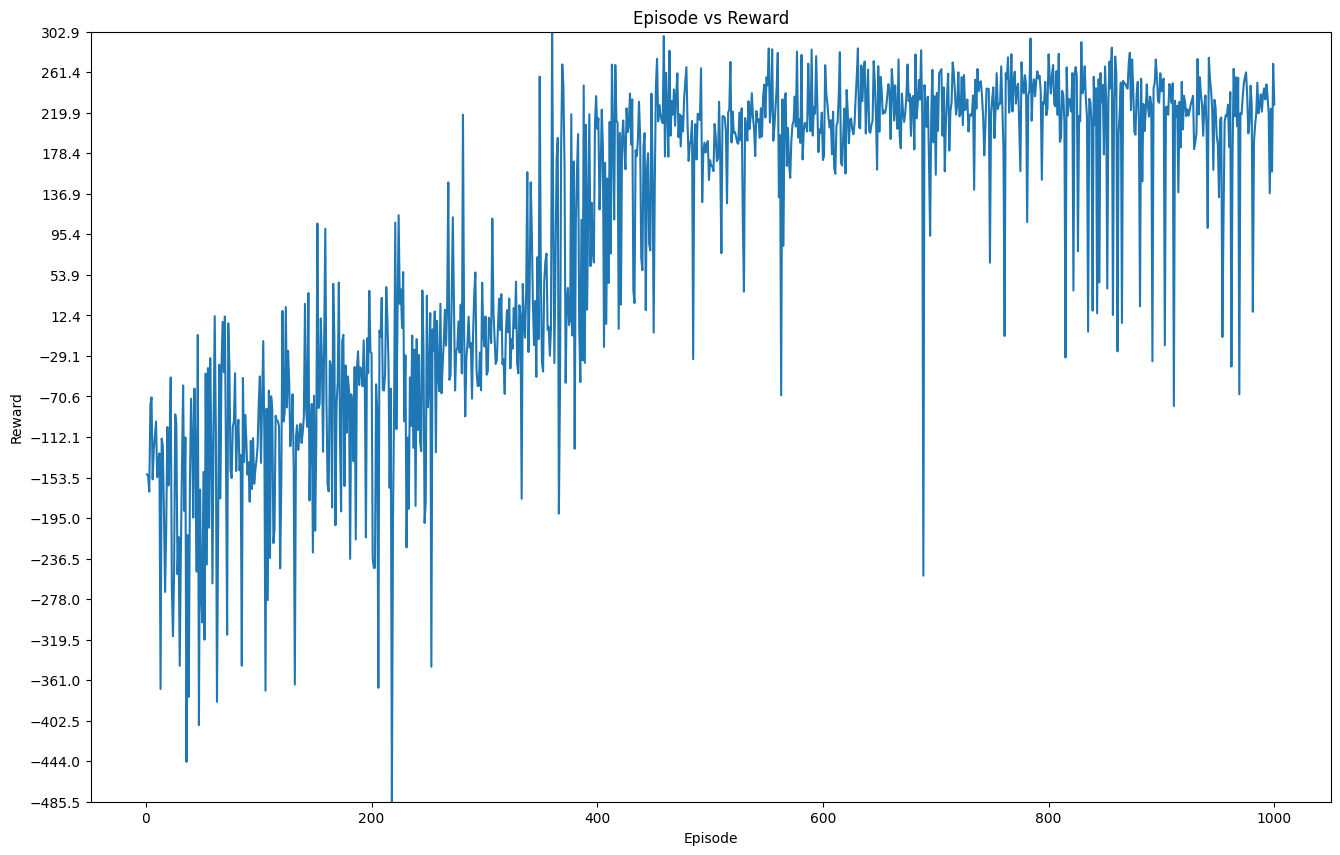

In [7]:
# draw the rewards data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_file = 'rewards.csv'
rewards_data = pd.read_csv(data_file, header=0)
rewards_data = rewards_data.dropna()
# rewards_data["loss"] = rewards_data["tensor_loss1"].str.split("(").str[1].astype(float)
# rewards_data.head()

rewards_data = rewards_data[:1000]
plt.figure(figsize=(16, 10))

def draw_fig(c1: int, c2: int, y_tick: int, y_min: int = -1, y_max: int = -1, 
             horizontal_line: bool = False):
    plt.xlabel(rewards_data.columns.values[c1])
    plt.ylabel(rewards_data.columns.values[c2])
    plt.title('{} vs {}'.format(rewards_data.columns.values[c1], rewards_data.columns.values[c2]))
    if y_min == -1:
        y_min = rewards_data.iloc[:,c2].min()
    if y_max == -1:
        y_max = rewards_data.iloc[:,c2].max()
    y_ticks = np.linspace(y_min, y_max, y_tick)
    plt.yticks(y_ticks)
    plt.ylim(y_min, y_max)

    plt.plot(rewards_data.iloc[:,c1], rewards_data.iloc[:,c2]) 
    # draw a horizontal line
    if horizontal_line:
        plt.axhline(y=1, color='r', linestyle='--')
    plt.show()

rewards_data.head()
# draw_reward()
# loss
# draw_fig(0,3, 20, y_max=-1, horizontal_line=True)
# rewards
draw_fig(0,1, 20)
# draw_fig(0,3, 20, y_max=-1, horizontal_line=True)


# Other Code

## DQN

## PPO
